# TNE 2: Principal Component Analysis

The purpose of this tutorial is to use Principal Component Analysis (PCA) 
for dimension reduction applied to images.


In [58]:
from pylab import *
import numpy as np
import matplotlib.pyplot as plt

from numpy import linalg as la

## 1. Application: handwritten digits recognition 5 & 6
We load 2 matrices which contain each a sequence of examples of 16x16 images of handwritten digits which are 5 and 6 here. Each line of the matrix contains 256 pixel values coding for the gray level of a 16x16 image.

In [59]:
train_5 = np.loadtxt('train_5.txt',delimiter=',')   # 556 samples
train_6 = np.loadtxt('train_6.txt',delimiter=',')   # 664 samples

#### Examples of images:

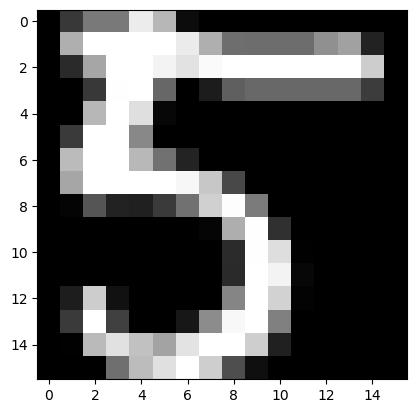

In [60]:
# Digit 5
n=9;
I = np.reshape(train_5[n,:],(16,16))

plt.imshow(I,cmap='gray')
plt.show()

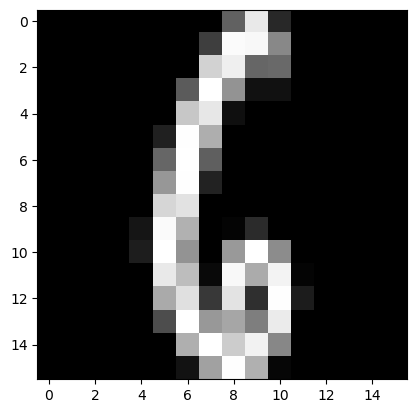

In [61]:
# Digit 6
n=5;
I = reshape(train_6[n,:],(16,16))

plt.imshow(I,cmap='gray')
plt.show()

#### Separating the training and test sets

We keep in the training set the 145 first images of 5s and the 200 first
images of 6s:

In [62]:
x_train_brut = np.vstack((train_5[:145,:], train_6[:200,:]))
N_train = np.size(x_train_brut,axis=0)
class_train = np.ones((345,1))   # label 1 for digit 6
class_train[:145] = 0       # label 0 for digit 5

x_test_brut = np.vstack((train_5[145:,:], train_6[200:,:]))
N_test = np.size(train_5,axis=0)+np.size(train_6,axis=0)-N_train

## 2. Principal Component Analysis

The purpose of this part is to observe the respective contributions of
each component of a PCA of images of 5. The function `sklearn.decomposition.PCA` of `scikit-learn` is available. In practice, one must first estimate the mean vector and then work with centered data. 

### Documentation
First have a look at
http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
    

In [63]:
# Principal component analysis
moy_train = x_train_brut.mean(axis=0)  # all the data, 5 & 6
x_train_centre = x_train_brut-np.tile(moy_train,(N_train,1))

# PCA from scikit-learn
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(x_train_centre)  # you may forget centering that is done by sklearn PCA

singval = pca.singular_values_   # eigenvalues
comp = pca.components_           # principal components
proj = pca.transform(x_train_centre)  # computes the projection coefficients

### Display the averaged images of 5 & 6 respectively

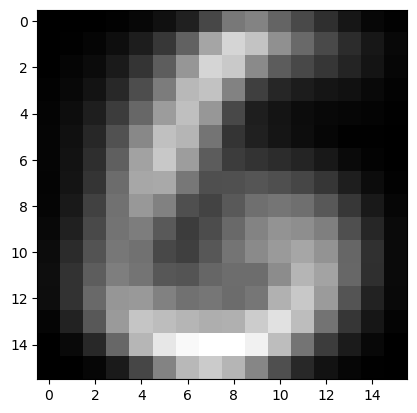

In [64]:
I_moy = np.reshape(moy_train,(16,16))   # averaged image = mean 
plt.imshow(I_moy,cmap = 'gray')
plt.show()

### Display an example rebuilt from the 1st component only

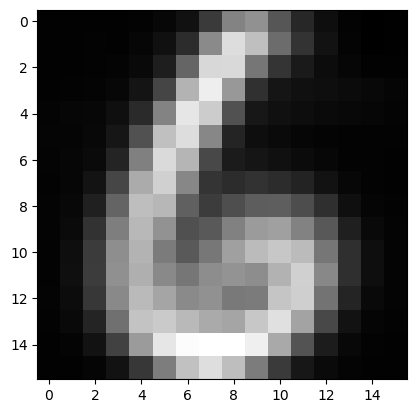

In [65]:
n=12   # choice of image no n=12 or any other

I = I_moy + proj[n,0]*np.reshape(comp[0,:],(16,16))  # adding the 1st PCA component 
plt.imshow(I,cmap='gray')
plt.show()

## Exercise 1: PCA & approximation

1. Read the documentation of function `PCA` and identify the input and output parameters.
2. Implement a progressive reconstruction of an image of digit 5 by adding the successive 
contribution of principal components.
3. Observe graphical results. How many components are necessary to obtain a 
reconstruction that you may consider as acceptable? nice? very nice?
4. Optional question: do the same for 6.


Most important parameters of the PCA class:


 Input Parameters:
 - the input data
 - n_components: Number of components to keep.
 - copy: If True, a copy of the input data is created.
 - whiten: When True, ensures uncorrelated outputs with unit variances.

 Output Attributes:
 - components_: Principal axes in feature space.
 - explained_variance_: Amount of variance explained by each selected component.
 - explained_variance_ratio_: Percentage of variance explained by each component.
 - singular_values_: Singular values corresponding to each component.
 - mean_: Per-feature empirical mean.
 - n_components_: Estimated number of components.

### Question 2 


>We will start by training the PCA only on the dataset of 5s, and then we will compare the results when trained with the full dataset

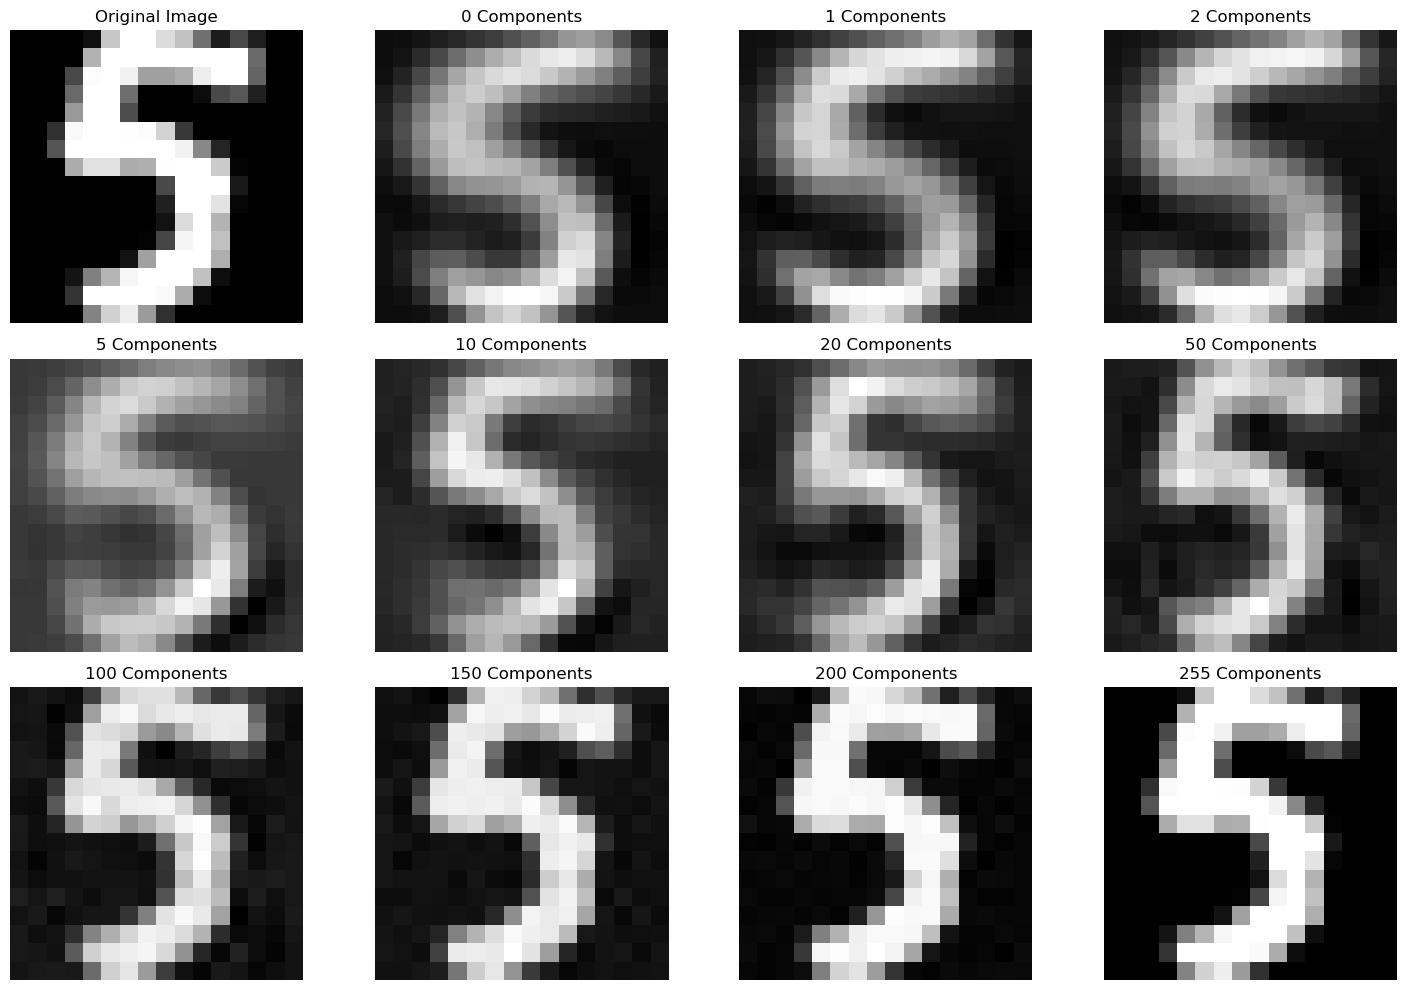

In [66]:
from sklearn.decomposition import PCA

moy_train = train_5.mean(axis=0)  # all the data = 5 
train_5_centre = train_5-np.tile(moy_train,(np.size(train_5, axis=0),1))
pca = PCA()
pca.fit(train_5_centre) 

checkpoints = [0, 1, 2, 5, 10, 20, 50, 100, 150, 200, 255] # checkpoints data of the reconstruction to be displayed

def progressive_reconstruction(image, pca, mean, checkpoints):
    """
    Perform progressive reconstruction of an image using PCA components.

    Parameters:
    - image (numpy.ndarray): Input image.
    - pca (sklearn.decomposition.PCA): Trained PCA model.
    - mean (numpy.ndarray): Per-feature empirical mean.
    - checkpoints (list): List of indices indicating checkpoints for progressive reconstruction.

    Returns:
    - reconstructions (list): List of tuples containing reconstructed images and corresponding checkpoint indices.
    """
    reconstructions = []
    image_centred = image.flatten() - mean
    image_proj = np.dot(image_centred, pca.components_.T) # Projection de l'image centré dans les composantes principales
    #image_proj = pca.transform(image.reshape(1, -1))Ò
     
    reconstructed = np.zeros(pca.components_[0].shape) # Démarre à zeros
    for i in range(pca.n_components_):
        reconstructed += image_proj[i] * pca.components_[i] # ajout progressif
        if i in checkpoints:  # Ajoute la reconstruction à la liste de checkpoints
            reconstructions.append((reconstructed.reshape(16, 16) + mean.reshape(16, 16), i))
    return reconstructions

# Selectionne un 5 
n = 121
train_5 = np.loadtxt('train_5.txt', delimiter=',')
image_5 = train_5[n,:].reshape(16, 16)  # Reshape

# Progressive reconstructions
reconstructed_images = progressive_reconstruction(image_5, pca, moy_train,checkpoints)

# Affichage
plt.figure(figsize=(15, 10))
plt.subplot(3, 4, 1)
plt.imshow(image_5, cmap='gray')
plt.title("Original Image")
plt.axis('off')

for i, (new_image, num_comp) in enumerate(reconstructed_images, start=1):
        plt.subplot(3, 4, i + 1)
        plt.imshow(new_image, cmap='gray')
        plt.title(f'{num_comp} Components')
        plt.axis('off')

plt.tight_layout()
plt.show()

> Les observations graphiques sont claires. On voit une augmentation croissante de la qualité de l'image à mesure que le nombre de composants augmentent. Graphiquement, je dirais que les résultats sont :
> - **acceptables** : à partir de 10 composants. 
> - **Bien/Beau** : à partir de 50 composants. 
> - **Très bien** : à partir de 150 composants. 

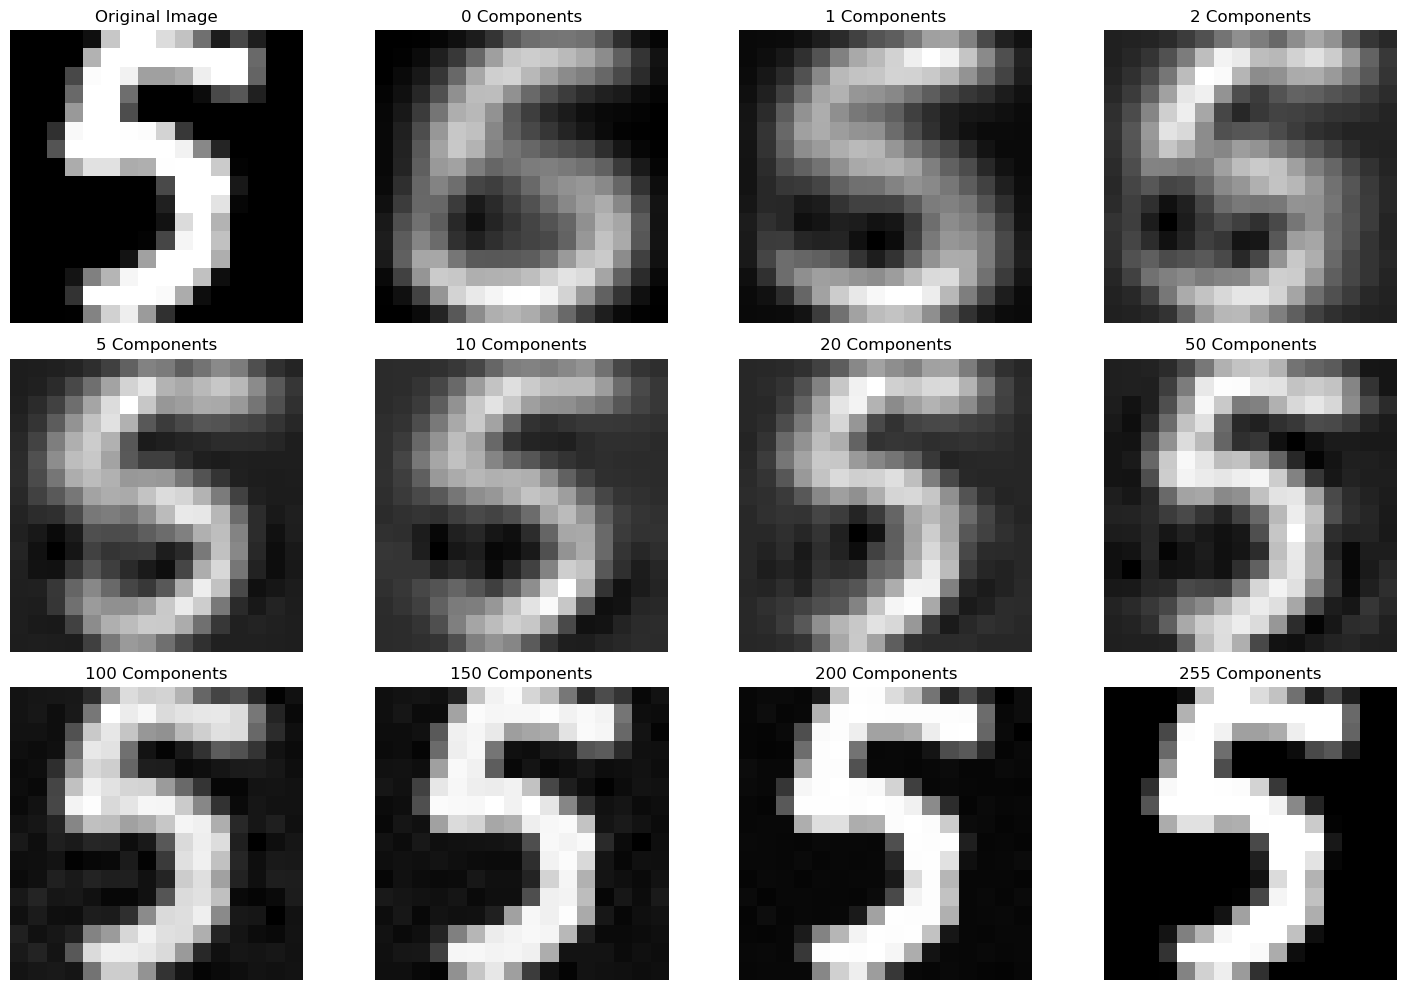

In [67]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(x_train_centre) 
moy_train = x_train_brut.mean(axis=0)
checkpoints = [0, 1, 2, 5, 10, 20, 50, 100, 150, 200, 255] # checkpoints data of the reconstruction to be displayed

# Selectionne un 5 
n = 121
train_5 = np.loadtxt('train_5.txt', delimiter=',')
image_5 = train_5[n,:].reshape(16, 16)  # Reshape

# Progressive reconstructions
reconstructed_images = progressive_reconstruction(image_5, pca, moy_train,checkpoints)

# Affichage
plt.figure(figsize=(15, 10))
plt.subplot(3, 4, 1)
plt.imshow(image_5, cmap='gray')
plt.title("Original Image")
plt.axis('off')

for i, (new_image, num_comp) in enumerate(reconstructed_images, start=1):
        plt.subplot(3, 4, i + 1)
        plt.imshow(new_image, cmap='gray')
        plt.title(f'{num_comp} Components')
        plt.axis('off')

plt.tight_layout()
plt.show()

When used witht the full dataset, the results are very similar. At the beginning it is a bit worse but it gets corrected quickly.

> We will now do the same for the 6s, starting the PCA with only the images of 6s and then with the full dataset.

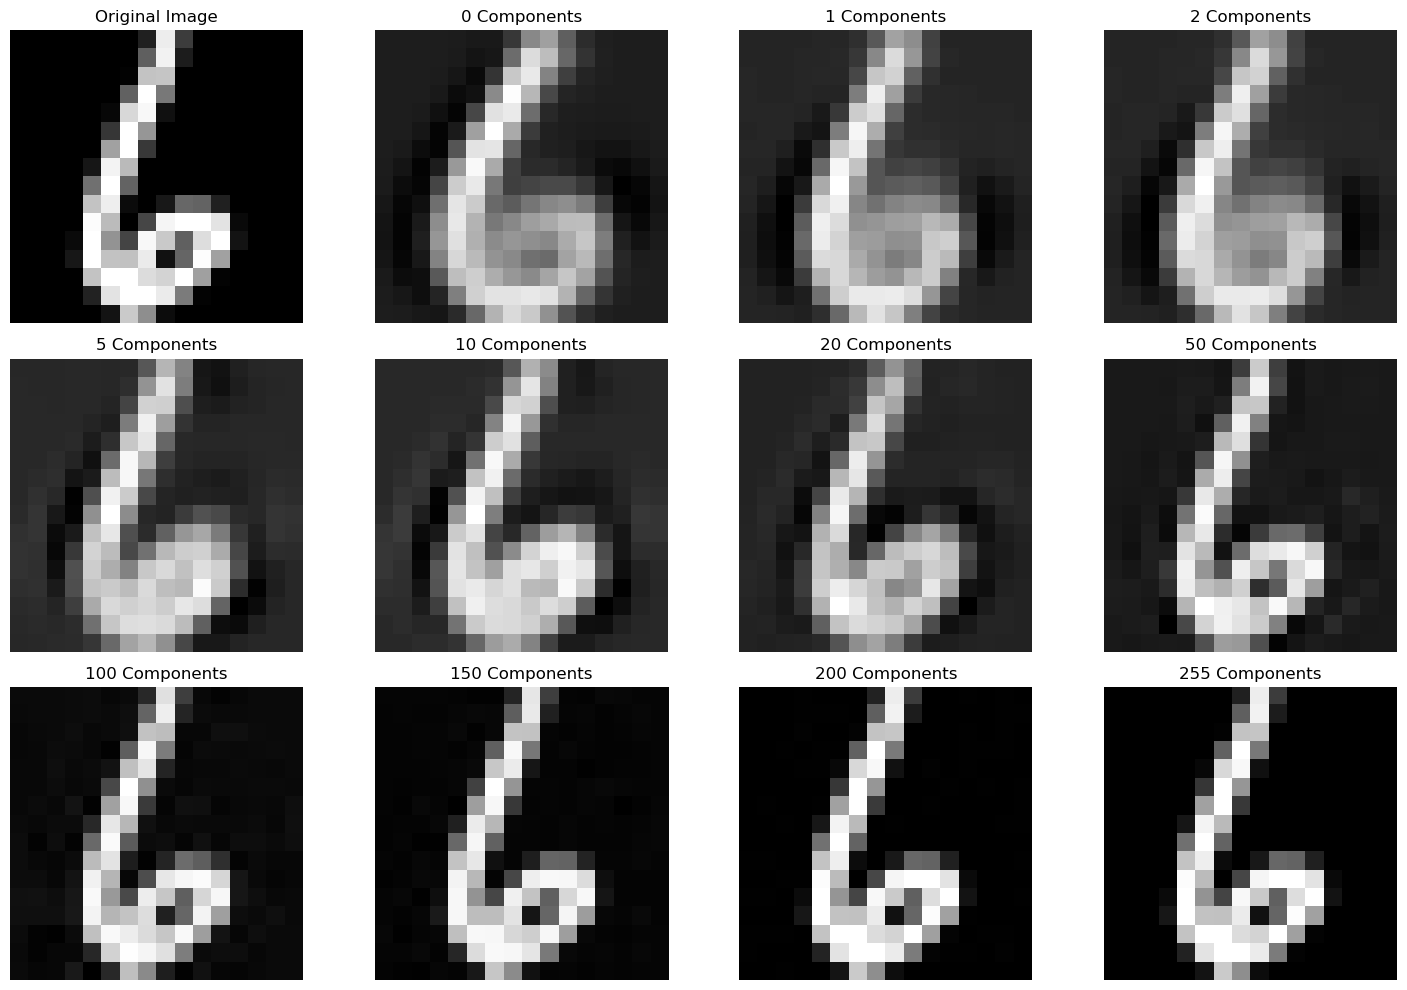

In [68]:
# Centrage des données du chiffre 6 et application de l'ACP
moy_train_6 = train_6.mean(axis=0)
train_6_centre = train_6 - np.tile(moy_train_6, (np.size(train_6, axis=0), 1))

# Application de l'ACP sur les données centrées du chiffre 6
pca_6 = PCA()
pca_6.fit(train_6_centre)
n = 121
train_6 = np.loadtxt('train_6.txt', delimiter=',')
image_6 = train_6[n,:].reshape(16, 16)  # Reshape

# Progressive reconstructions
reconstructed_images = progressive_reconstruction(image_6, pca_6, moy_train_6,checkpoints)
# Affichage
plt.figure(figsize=(15, 10))
plt.subplot(3, 4, 1)
plt.imshow(image_6, cmap='gray')
plt.title("Original Image")
plt.axis('off')

for i, (new_image, num_comp) in enumerate(reconstructed_images, start=1):
        plt.subplot(3, 4, i + 1)
        plt.imshow(new_image, cmap='gray')
        plt.title(f'{num_comp} Components')
        plt.axis('off')

plt.tight_layout()
plt.show()

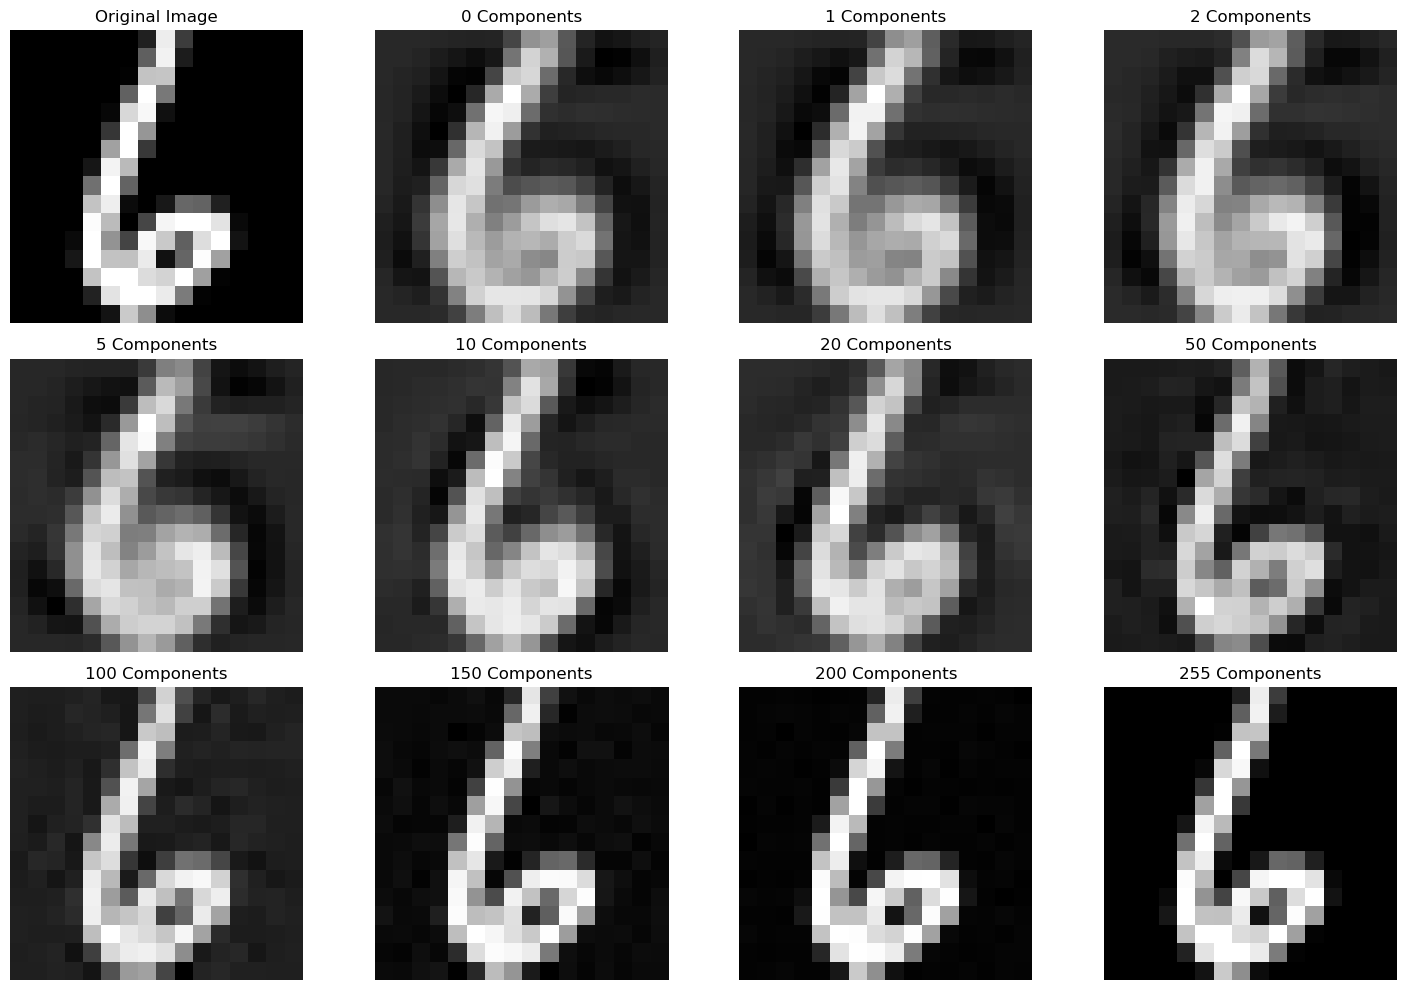

In [69]:

# Application de l'ACP sur les données centrées du chiffre 6
pca_6 = PCA()
pca_6.fit(x_train_centre)
moy_train = x_train_brut.mean(axis=0)
n = 121
train_6 = np.loadtxt('train_6.txt', delimiter=',')
image_6 = train_6[n,:].reshape(16, 16)  # Reshape

# Progressive reconstructions
reconstructed_images = progressive_reconstruction(image_6, pca_6, moy_train,checkpoints)
# Affichage
plt.figure(figsize=(15, 10))
plt.subplot(3, 4, 1)
plt.imshow(image_6, cmap='gray')
plt.title("Original Image")
plt.axis('off')

for i, (new_image, num_comp) in enumerate(reconstructed_images, start=1):
        plt.subplot(3, 4, i + 1)
        plt.imshow(new_image, cmap='gray')
        plt.title(f'{num_comp} Components')
        plt.axis('off')

plt.tight_layout()
plt.show()

With the 6s, the results are similar. The quality of the images is a bit worse than with the 5s, but the same conclusions can be drawn.

## Exercise 2: PCA & classification
1. Use `proj[0:2,:]` as the coordinates of a point representing each sample
of the training set in a plane. Display the cloud of points associated to
digits 5 and 6 by using 2 different colors.
2. Comment on the repartition of points in the plane. 
3. Do you see how this PCA step makes possible the use of a much simpler classification? 
What would you propose as an alternative to logistic regression of TP3 then?


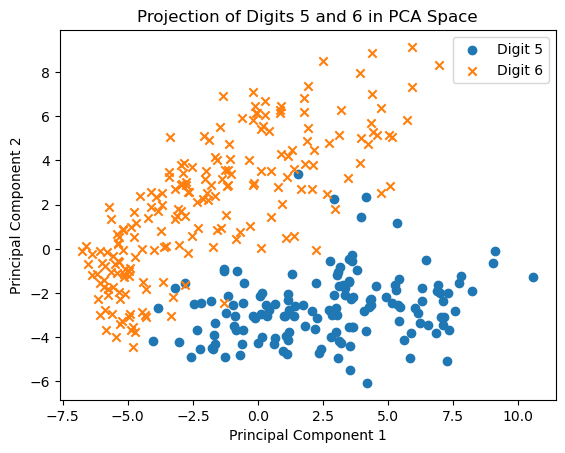

In [70]:

# 1. Load or generate image data
train_5 = np.loadtxt('train_5.txt', delimiter=',')
train_6 = np.loadtxt('train_6.txt', delimiter=',')

# Concatenate the datasets of digits 5 and 6
x_train_brut = np.vstack((train_5[:145,:], train_6[:200,:]))

# Apply PCA
pca = PCA()
pca.fit(x_train_brut)
proj = pca.transform(x_train_brut)

# Use proj[0:2, :] as the coordinates of a point representing each sample in a plane
plt.scatter(proj[:145, 0], proj[:145, 1], label='Digit 5', marker='o')
plt.scatter(proj[145:, 0], proj[145:, 1], label='Digit 6', marker='x')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Projection of Digits 5 and 6 in PCA Space')
plt.legend()
plt.show()
plt.show()

## Beyong this lab

Have a look at other examples of applications, like

http://scikit-learn.org/stable/auto_examples/decomposition/plot_faces_decomposition.html#sphx-glr-auto-examples-decomposition-plot-faces-decomposition-py
    